In [2]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt
import numpy as np

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

Consider the ode:
$$
y_1' = y_1, \\
y_2' = y_1 - y_2, \\
y_3' = y_2,
$$

Initial Condition:
$$
y_1(0) = 1, \\
y_2(0) = 0, \\
y_3(0) = 0
$$



In [12]:
# data range
x = torch.Tensor(np.linspace(0, 10, 25))
x

tensor([[ 0.0000],
        [ 0.4167],
        [ 0.8333],
        [ 1.2500],
        [ 1.6667],
        [ 2.0833],
        [ 2.5000],
        [ 2.9167],
        [ 3.3333],
        [ 3.7500],
        [ 4.1667],
        [ 4.5833],
        [ 5.0000],
        [ 5.4167],
        [ 5.8333],
        [ 6.2500],
        [ 6.6667],
        [ 7.0833],
        [ 7.5000],
        [ 7.9167],
        [ 8.3333],
        [ 8.7500],
        [ 9.1667],
        [ 9.5833],
        [10.0000]])

In [4]:
# full connected network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.silu = nn.SiLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.silu(out)
        out = self.l2(out)
        return out

In [5]:
# N is a Neural Network - has 1 hidden layer
N = NeuralNet(1, 8, 3).to(device)

# Initial condition
A = torch.tensor([0.0, 1.0, 0.0])

# The Psi_t function 
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, y_1, y_2, y_3: torch.stack([-y_1, y_1 - y_2, y_2],1)

In [6]:
def derivative(func, input):
    jac = jacobian(func, input)

    i = np.arange(len(input))
    return jac[i, :, i].reshape((len(input), 3))

In [11]:
ic_loss = []
loss_func = []
loss = []

# The loss function
def loss_odes(x):
    x.requires_grad = True

    y_1, y_2, y_3 = N(x).T
    dy_1, dy_2, dy_3 = derivative(N, x).T

    l1 = torch.sum((dy_1 + y_1)**2)
    l2 = torch.sum((dy_2 - y_1 + y_2)**2)
    l3 = torch.sum((dy_3 - y_2)**2)

    ic = torch.sum((torch.tensor([y_1[0], y_2[0], y_3[0]])- A)**2)

    ic_loss.append(ic)
    loss_func.append(l1 + l2 + l3)
    loss.append(l1 + l2 + l3 + ic)

    return l1 + l2 + l3 + ic

    # outputs = Psi_t(x)
    # Psi_t_x = derivative(Psi_t, x)
    # return torch.mean(torch.sum((Psi_t_x - f(x, outputs[:,0], outputs[:,1], outputs[:,2])) ** 2, dim=1))


# Optimize
optimizer = torch.optim.Adam(N.parameters(), lr=0.005) 

n_epoch = 1000
# traning loop
for epoch in range(n_epoch):

    optimizer.zero_grad()

    # forward
    l = loss_odes(x)
    
    # backward
    l.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'epoch {epoch+1}, loss = {l.item():.4f}')

y_1:  tensor([-0.0123, -0.0110, -0.0099, -0.0091, -0.0084, -0.0078, -0.0072, -0.0067,
        -0.0063, -0.0061, -0.0061, -0.0063, -0.0068, -0.0076, -0.0086, -0.0098,
        -0.0112, -0.0127, -0.0142, -0.0157, -0.0172, -0.0184, -0.0194, -0.0202,
        -0.0207], grad_fn=<UnbindBackward>)
1:  tensor([-0.0123, -0.0110, -0.0099, -0.0091, -0.0084, -0.0078, -0.0072, -0.0067,
        -0.0063, -0.0061, -0.0061, -0.0063, -0.0068, -0.0076, -0.0086, -0.0098,
        -0.0112, -0.0127, -0.0142, -0.0157, -0.0172, -0.0184, -0.0194, -0.0202,
        -0.0207], grad_fn=<SelectBackward>)
y[0]:  [tensor(-0.0123, grad_fn=<SelectBackward>), tensor(0.0280, grad_fn=<SelectBackward>), tensor(-0.0783, grad_fn=<SelectBackward>)]
y_1:  tensor([-0.0199, -0.0177, -0.0155, -0.0133, -0.0110, -0.0085, -0.0060, -0.0034,
        -0.0008,  0.0017,  0.0040,  0.0061,  0.0078,  0.0093,  0.0105,  0.0114,
         0.0120,  0.0125,  0.0129,  0.0133,  0.0136,  0.0141,  0.0148,  0.0157,
         0.0169], grad_fn=<UnbindBackwar

KeyboardInterrupt: 

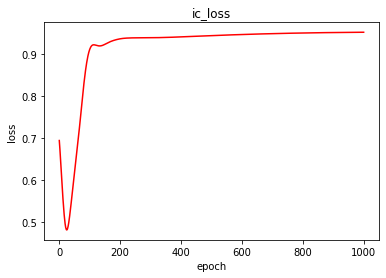

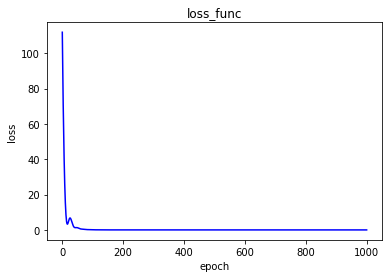

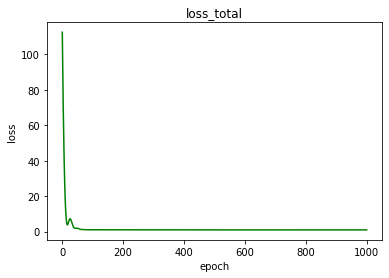

In [8]:
epoch = np.linspace(0, n_epoch, n_epoch)[:, None]

with torch.no_grad():
    plt.plot(epoch, ic_loss, '-r')
    plt.title('ic_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    plt.plot(epoch, loss_func, '-b')
    plt.title('loss_func')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    plt.plot(epoch, loss, '-g')
    plt.title('loss_total')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Text(0, 0.5, 'C')

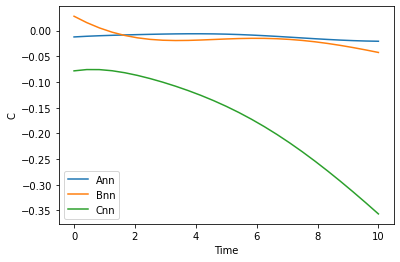

In [9]:
# Let's compare the result to the true solution
xx = np.linspace(0, 10, 25)[:, None]
with torch.no_grad():
    yy = N(torch.Tensor(xx)).numpy()

plt.plot(xx, yy, '-')
plt.legend(['Ann', 'Bnn', 'Cnn'])
plt.xlabel('Time')
plt.ylabel('C')

Text(0, 0.5, 'C')

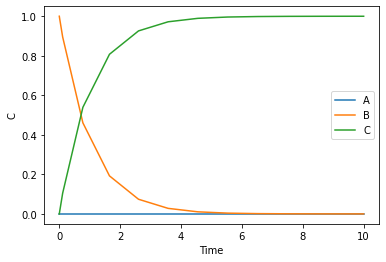

In [10]:
from scipy.integrate import solve_ivp

def ode(t, C):
    Ca, Cb, Cc = C
    dCadt = -Ca
    dCbdt = Ca - Cb
    dCcdt = Cb
    return [dCadt, dCbdt, dCcdt]

C0 = [1.0, 0.0, 0.0]
k1 = 1
k2 = 1

sol = solve_ivp(ode, (0, 10), A.numpy())

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T)
plt.legend(['A', 'B', 'C'])
plt.xlabel('Time')
plt.ylabel('C')